<a href="https://colab.research.google.com/github/bjpeters2/bjpeters2/blob/main/nyc_schools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

This is a basic analysis of demographic and survey data from New York City high schools as they relate to the average SAT performance of the schools. The project grew out of a guided project from Dataquest with additional classifier models, about which I learned in later coursework. It utilizes datasets from Kaggle (linked below) that are cleaned and aggregated before analysis.

The project takes the following form:
1. Data import and cleaning: preparation of data for analysis, including decision-making with respect to null or missing values and appropriate joining techniques.
2. Descripive analysis, including correlation analysis and spatial representation of key data features using Folium.
3. Classifier models, including a comparison of linear and nonlinear models and hyperparameter tuning.
4. A brief conclusion.

**Tools used:**
- Descriptive data analysis: correlation coefficients (heat maps), spatial analysis with Folium, basic plotting and table production
- Linear SGD classifier with manual hyperparameter tuning
- Decision tree classification with GridSearch hyperparameter tuning, visualization of decision tree


Kaggle dataset: https://www.kaggle.com/datasets/samaxtech/nyc-high-school-data/data

# **1. Data import and cleaning**

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import data files (CSV)
import pandas as pd

data_files = ["ap_2010.csv",
              "class_size.csv",
              "demographics.csv",
              "graduation.csv",
              "hs_directory.csv",
              "sat_results.csv"]

data = {}

for file in data_files:
  d = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/School demographics & tests/{0}".format(file))
  data[file.replace(".csv", "")] = d

In [3]:
# Import surveys (tab-delimited TXT)
all_survey = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/School demographics & tests/survey_all.txt", delimiter="\t", encoding="windows-1252")
d75_survey = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/School demographics & tests/survey_d75.txt", delimiter="\t", encoding="windows-1252")
survey = pd.concat([all_survey, d75_survey], axis=0)

survey.head()

,dbn,bn,schoolname,d75,studentssurveyed,highschool,schooltype,rr_s,rr_t,rr_p,...,s_q14_2,s_q14_3,s_q14_4,s_q14_5,s_q14_6,s_q14_7,s_q14_8,s_q14_9,s_q14_10,s_q14_11
0,01M015,M015,P.S. 015 Roberto Clemente,0,No,0.0,Elementary School,NaN,88,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,M019,P.S. 019 Asher Levy,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,M020,P.S. 020 Anna Silver,0,No,0.0,Elementary School,NaN,88,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,M034,P.S. 034 Franklin D. Roosevelt,0,Yes,0.0,Elementary / Middle School,89.0,73,50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,M063,P.S. 063 William McKinley,0,No,0.0,Elementary School,NaN,100,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Keep only rows of survey file that aren't commonly NaN
survey_fields = [
    "dbn",
    "rr_s",
    "rr_t",
    "rr_p",
    "N_s",
    "N_t",
    "N_p",
    "saf_p_11",
    "com_p_11",
    "eng_p_11",
    "aca_p_11",
    "saf_t_11",
    "com_t_11",
    "eng_t_11",
    "aca_t_11",
    "saf_s_11",
    "com_s_11",
    "eng_s_11",
    "aca_s_11",
    "saf_tot_11",
    "com_tot_11",
    "eng_tot_11",
    "aca_tot_11"
    ]

survey = survey.loc[:, survey_fields]

# Rename DBN column
survey = survey.rename(columns={"dbn": "DBN"})

# Examine survey dataset
survey.head()

,DBN,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_p_11,com_p_11,eng_p_11,...,eng_t_11,aca_t_11,saf_s_11,com_s_11,eng_s_11,aca_s_11,saf_tot_11,com_tot_11,eng_tot_11,aca_tot_11
0,01M015,NaN,88,60,NaN,22.0,90.0,8.5,7.6,7.5,...,7.6,7.9,NaN,NaN,NaN,NaN,8.0,7.7,7.5,7.9
1,01M019,NaN,100,60,NaN,34.0,161.0,8.4,7.6,7.6,...,8.9,9.1,NaN,NaN,NaN,NaN,8.5,8.1,8.2,8.4
2,01M020,NaN,88,73,NaN,42.0,367.0,8.9,8.3,8.3,...,6.8,7.5,NaN,NaN,NaN,NaN,8.2,7.3,7.5,8.0
3,01M034,89.0,73,50,145.0,29.0,151.0,8.8,8.2,8.0,...,6.8,7.8,6.2,5.9,6.5,7.4,7.3,6.7,7.1,7.9
4,01M063,NaN,100,60,NaN,23.0,90.0,8.7,7.9,8.1,...,7.8,8.1,NaN,NaN,NaN,NaN,8.5,7.6,7.9,8.0


In [5]:
# Clean sat_results dataset
import numpy as np

# Convert SAT scores to numeric data type
scores = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for score in scores:
  data["sat_results"][score] = pd.to_numeric(data["sat_results"][score], errors="coerce")

# Calculate total SAT scores from scores of individual sections
data["sat_results"]["total_sat_score"] = data["sat_results"]["SAT Math Avg. Score"] + data["sat_results"]["SAT Critical Reading Avg. Score"] + data["sat_results"]["SAT Writing Avg. Score"]

# Rename columns
data["sat_results"] = data["sat_results"].rename(columns={"Num of SAT Test Takers": "n_sat_test_takers",
                                                          "SAT Critical Reading Avg. Score": "sat_reading_score",
                                                          "SAT Math Avg. Score": "sat_math score",
                                                          "SAT Writing Avg. Score": "sat_writing_score",
                                                          "SCHOOL NAME": "school_name"})

# Convert columns to numeric type
columns = ["n_sat_test_takers", "sat_reading_score", "sat_math score", "sat_writing_score", "total_sat_score"]
for column in columns:
  data["sat_results"][column] = pd.to_numeric(data["sat_results"][column], errors="coerce")

# Aggregate duplicate records for the same school using their DBN identifiers
data["sat_results"] = data["sat_results"].groupby("DBN").agg({"DBN": 'first',
                                                              "school_name" : 'first',
                                                              "n_sat_test_takers": np.mean,
                                                              "sat_reading_score": np.mean,
                                                              "sat_math score": np.mean,
                                                              "sat_writing_score": np.mean,
                                                              "total_sat_score": np.mean
                                                              }).reset_index(drop=True)

# Remove results from schools with no SAT test takers (NaN or n_sat_test_takers = 0)
data["sat_results"] = data["sat_results"].drop(data["sat_results"][data["sat_results"]["n_sat_test_takers"].isnull()].index)
data["sat_results"] = data["sat_results"].drop(data["sat_results"][data["sat_results"]["n_sat_test_takers"] == 0].index)
data["sat_results"] = data["sat_results"].reset_index(drop=True)

# Check result
print("Number of rows witn NaN SAT scores: ", data["sat_results"]["total_sat_score"].isnull().sum())
data["sat_results"].head()

Number of rows witn NaN SAT scores:  0


<ipython-input-5-5043fbcc1775>:25: FutureWarning: The provided callable <function mean at 0x7eac8223fd00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data["sat_results"] = data["sat_results"].groupby("DBN").agg({"DBN": 'first',


,DBN,school_name,n_sat_test_takers,sat_reading_score,sat_math score,sat_writing_score,total_sat_score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29.0,355.0,404.0,363.0,1122.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91.0,383.0,423.0,366.0,1172.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70.0,377.0,402.0,370.0,1149.0
3,01M458,FORSYTH SATELLITE ACADEMY,7.0,414.0,401.0,359.0,1174.0
4,01M509,MARTA VALLE HIGH SCHOOL,44.0,390.0,433.0,384.0,1207.0


In [6]:
# Clean ap_2010 dataset
# Assume 's' entries in AP scores represent 0
data["ap_2010"] = data["ap_2010"].replace("s", 0)

# Convert AP scores to numeric data type
scores = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']
for score in scores:
  data["ap_2010"][score] = pd.to_numeric(data["ap_2010"][score], errors="coerce")

# Add column for average tests per students and pass rate
data["ap_2010"]["avg_APtests_per_student"] = data["ap_2010"]["Total Exams Taken"] / data["ap_2010"]["AP Test Takers "]
data["ap_2010"]["ap_test_pass_rate"] = data["ap_2010"]["Number of Exams with scores 3 4 or 5"] / data["ap_2010"]["Total Exams Taken"]

# Rename columns to include AP designator
data["ap_2010"] = data["ap_2010"].rename(columns={"Total Exams Taken": "total_ap_exams_taken",
                                                  "Number of Exams with scores 3 4 or 5": "ap_exams_passed",
                                                  "AP Test Takers ": "ap_test_takers",
                                                  "SchoolName": 'school_name'})

# Aggregate duplicate records for the same school using their DBN identifiers
data["ap_2010"] = data["ap_2010"].groupby("DBN").agg({"DBN": 'first',
                                                      "school_name" : 'first',
                                                      "ap_exams_passed": np.mean,
                                                      "ap_test_takers": np.mean,
                                                      "total_ap_exams_taken": np.mean,
                                                      "avg_APtests_per_student": np.mean,
                                                      "ap_test_pass_rate": np.mean
                                                      }).reset_index(drop=True)

# Drop school_name column that already appears in the SAT score database
data["ap_2010"] = data["ap_2010"].drop(columns=["school_name"])

# Assume zero tests taken for null values
# data["ap_2010"] = data["ap_2010"].fillna(value=0, axis=0)

# Check result
data["ap_2010"].head()

<ipython-input-6-a427f143e351>:21: FutureWarning: The provided callable <function mean at 0x7eac8223fd00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data["ap_2010"] = data["ap_2010"].groupby("DBN").agg({"DBN": 'first',


,DBN,ap_exams_passed,ap_test_takers,total_ap_exams_taken,avg_APtests_per_student,ap_test_pass_rate
0,01M448,10.0,39.0,49.0,1.256410,0.204082
1,01M450,0.0,19.0,21.0,1.105263,0.000000
2,01M515,24.0,24.0,26.0,1.083333,0.923077
3,01M539,191.0,255.0,377.0,1.478431,0.506631
4,02M296,0.0,0.0,0.0,NaN,NaN


In [7]:
# Clean hs_directory dataset
# Convert locational infomation into simple lat/long coordinates
import re

def get_lat_lon(loc):
  coords = re.findall("\(.+, .+\)", loc)
  lat = coords[0].split(",")[0].replace("(", "")
  lon = coords[0].split(",")[1].replace(")", "").strip()

  return lat, lon

lat_lon = data["hs_directory"]["Location 1"].apply(get_lat_lon)

data["hs_directory"]["lat"] = lat_lon.apply(lambda x: x[0])
data["hs_directory"]["lon"] = lat_lon.apply(lambda x: x[1])

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Map Boro to numerical code
data["hs_directory"]["boro_code"] = data["hs_directory"]["boro"].replace({"Brooklyn": 0,
                                                                          "Bronx": 1,
                                                                          "Manhattan": 2,
                                                                          "Queens": 3,
                                                                          "Staten Island": 4})

# Rename DBN column for consistency with other datasets
data["hs_directory"]['DBN'] = data["hs_directory"]["dbn"]

# Condense directory dataset to boro code and lat/long only
data["hs_directory"] = data["hs_directory"].loc[:, ["DBN", "boro_code", "lat", "lon"]]

# Aggregate duplicate records for the same school using their DBN identifiers
data["hs_directory"] = data["hs_directory"].groupby("DBN").agg({"DBN": 'first',
                                                                "boro_code" : 'first',
                                                                "lat": np.mean,
                                                                "lon": np.mean
                                                                }).reset_index(drop=True)

# Check result
data["hs_directory"].head()

<ipython-input-7-2ec2deb6f45e>:34: FutureWarning: The provided callable <function mean at 0x7eac8223fd00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data["hs_directory"] = data["hs_directory"].groupby("DBN").agg({"DBN": 'first',


,DBN,boro_code,lat,lon
0,01M292,2,40.713764,-73.985260
1,01M448,2,40.712332,-73.984797
2,01M450,2,40.729783,-73.983041
3,01M509,2,40.720569,-73.985673
4,01M539,2,40.718725,-73.979426


In [8]:
# Clean class_size dataset
# Pad DBN and CSN data in class_size to match other datasets
def pad_csd(num):
  string_representation = str(num)
  if len(string_representation) > 1:
    return string_representation
  else:
    return "0" + string_representation

# Pad CSD designator for transformation into DBN
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)

# Reconstruct DBN designator for future merger with other datasets
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Filter class_size dataset to represent only general education schools with grades 9-12
class_size = data["class_size"]
class_size = class_size[(class_size["GRADE "] == "09-12") & (class_size["PROGRAM TYPE"] == "GEN ED")]

# Rename relevant numerical columns and columns
class_size = class_size.rename(columns={'CORE SUBJECT (MS CORE and 9-12 ONLY)': 'subject',
                                        'AVERAGE CLASS SIZE': 'class_size_avg',
                                        'SIZE OF SMALLEST CLASS': 'smallest_class_n_students_avg',
                                        'SIZE OF LARGEST CLASS': 'largest_class_n_students_avg'})

# Condense dataset to only relevant numerical columns and columns for aggregation
class_size_subjects = class_size[["subject", "class_size_avg", "smallest_class_n_students_avg", "largest_class_n_students_avg", "DBN"]]
class_size = class_size[["class_size_avg", "smallest_class_n_students_avg", "largest_class_n_students_avg", "DBN"]]

# Aggregate duplicate records for the same school using their DBN identifiers
class_size = class_size.groupby("DBN").agg({"class_size_avg": np.mean,
                                            "smallest_class_n_students_avg": np.mean,
                                            "largest_class_n_students_avg": np.mean,
                                            "DBN": 'first'}).reset_index(drop=True)
class_size_subjects = class_size_subjects.groupby(["DBN", "subject"]).agg({"class_size_avg": np.mean,
                                                                           "smallest_class_n_students_avg": np.mean,
                                                                           "largest_class_n_students_avg": np.mean,
                                                                           "subject": 'first',
                                                                           "DBN": 'first'}).reset_index(drop=True)

# Merge testing variable back into main dataset
data["class_size"] = class_size

# Check result
data["class_size"].head()

<ipython-input-8-a7e5273e27a2>:31: FutureWarning: The provided callable <function mean at 0x7eac8223fd00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  class_size = class_size.groupby("DBN").agg({"class_size_avg": np.mean,
<ipython-input-8-a7e5273e27a2>:31: FutureWarning: The provided callable <function mean at 0x7eac8223fd00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  class_size = class_size.groupby("DBN").agg({"class_size_avg": np.mean,
<ipython-input-8-a7e5273e27a2>:35: FutureWarning: The provided callable <function mean at 0x7eac8223fd00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  class_size_subject

,class_size_avg,smallest_class_n_students_avg,largest_class_n_students_avg,DBN
0,22.564286,18.50,26.571429,01M292
1,22.000000,21.00,23.500000,01M332
2,33.000000,33.00,33.000000,01M378
3,22.231250,18.25,27.062500,01M448
4,21.200000,19.40,22.866667,01M450


In [9]:
# Clean demographics dataset, noting that this dataset includes all schools and not just high schools
# This will have to be resolved by joining method later

# Filter for useful columns only
data['demographics'] = data['demographics'].drop(columns=['schoolyear',
                                                          'Name',
                                                          'prek',
                                                          'k',
                                                          'grade1', 'grade2', 'grade3', 'grade4', 'grade5', 'grade6', 'grade7', 'grade8', 'grade9', 'grade10', 'grade11', 'grade12',
                                                          'ell_num',
                                                          'sped_num',
                                                          'asian_num', 'black_num', 'hispanic_num', 'white_num',
                                                          'male_num', 'female_num'
                                                          ])

# Convert non-numeric columns to numeric
cols = ['fl_percent', 'ctt_num', 'selfcontained_num']
for col in cols:
  data['demographics'][col] = pd.to_numeric(data['demographics'][col], errors='coerce')

# Rename columns with sector-specific acronyms
data['demographics'] = data['demographics'].rename(columns={'fl_percent': 'free_lunch_percent',
                                                            'frl_percent': 'free_reduced_lunch_percent',
                                                            'ell_percent': 'english_lerners_percent',
                                                            'sped_percent': 'special_ed_percent',
                                                            'ctt_num': 'n_students_collab_team_teaching',
                                                            'selfcontained_num': 'n_students_selfcontained_classrooms'})

# Aggregate duplicate records for the same school using their DBN identifiers
data['demographics'] = data['demographics'].groupby("DBN").agg({"DBN": "first",
                                                                "free_lunch_percent": np.mean,
                                                                "free_reduced_lunch_percent": np.mean,
                                                                "total_enrollment": np.mean,
                                                                "english_lerners_percent": np.mean,
                                                                "special_ed_percent": np.mean,
                                                                "n_students_collab_team_teaching": np.mean,
                                                                "n_students_selfcontained_classrooms": np.mean,
                                                                "asian_per": np.mean,
                                                                "black_per": np.mean,
                                                                "hispanic_per": np.mean,
                                                                "white_per": np.mean,
                                                                "male_per": np.mean,
                                                                "female_per": np.mean
                                                                }).reset_index(drop=True)


# Check result
data['demographics'].head()


<ipython-input-9-b39e511e5310>:30: FutureWarning: The provided callable <function mean at 0x7eac8223fd00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data['demographics'] = data['demographics'].groupby("DBN").agg({"DBN": "first",


,DBN,free_lunch_percent,free_reduced_lunch_percent,total_enrollment,english_lerners_percent,special_ed_percent,n_students_collab_team_teaching,n_students_selfcontained_classrooms,asian_per,black_per,hispanic_per,white_per,male_per,female_per
0,01M015,89.40,94.133333,233.857143,15.985714,22.357143,20.428571,12.142857,6.257143,30.857143,59.742857,2.271429,56.328571,43.671429
1,01M019,61.50,75.166667,336.285714,9.914286,21.228571,14.000000,21.714286,12.500000,24.814286,49.371429,8.714286,48.500000,51.500000
2,01M020,92.50,95.566667,648.285714,30.600000,14.485714,33.571429,21.142857,27.914286,7.757143,61.214286,1.942857,49.985714,50.014286
3,01M034,76.85,97.600000,411.857143,8.542857,24.400000,39.833333,30.428571,5.714286,21.071429,70.171429,1.871429,50.885714,49.114286
4,01M056,84.70,NaN,173.000000,11.000000,15.600000,5.000000,9.000000,46.800000,12.700000,38.200000,2.300000,54.300000,45.700000


In [10]:
# Clean graduation dataset
# Extract useful columns
useful = data['graduation'][['Dropped Out - % of cohort', 'Regents w/o Advanced - % of grads', 'Advanced Regents - % of grads']]

# Assume s entries represent 0, replace as such
# Remove % symbol from data
# Convert data to numerical type

def clean_useful(data):
  data = data.replace('s', '0%')
  for col in data.columns:
    data[col] = data[col].str.replace('%', '')
    for index in data.index:
      entry = data.loc[index, col]
      if type(entry) != float and entry.strip() == '.':
        data.loc[index, col] = 0
    data[col] = pd.to_numeric(data[col])
  return data

useful = clean_useful(useful)

# Merge useful columns back into dataset
data['graduation'][['avg_dropped_out_percent', 'avg_regents_no_advanced_percent', 'avg_regents_advanced_percent']] = useful

# Keep only useful columns
data['graduation'] = data['graduation'][['DBN', 'avg_dropped_out_percent', 'avg_regents_no_advanced_percent', 'avg_regents_advanced_percent']]

# Group data by school
data['graduation'] = data['graduation'].groupby('DBN').agg(np.mean).reset_index()

# Check result
data['graduation'].head()

<ipython-input-10-c676c861786d>:29: FutureWarning: The provided callable <function mean at 0x7eac8223fd00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  data['graduation'] = data['graduation'].groupby('DBN').agg(np.mean).reset_index()


,DBN,avg_dropped_out_percent,avg_regents_no_advanced_percent,avg_regents_advanced_percent
0,01M292,6.050000,35.224074,0.000000
1,01M448,6.854545,32.989610,9.279221
2,01M450,6.306579,59.188158,0.000000
3,01M509,8.097297,24.241892,10.859459
4,01M515,10.539726,19.460274,28.412329


In [11]:
# Combine the datasets
# The SAT database acts as the master here because it contains the target variables for investigation
combined_sat = data["sat_results"]

to_merge = ["ap_2010", "graduation", "class_size", "demographics", "hs_directory"]

for dataset in to_merge:
  combined_sat = combined_sat.merge(data[dataset], on="DBN", how="left")

# Check result
combined_sat.head()

# Combine survey results in separate dataset
combined_sat_survey = combined_sat.merge(survey, on="DBN", how="left")

# Combine SAT and survey results only
sat_survey = data["sat_results"].merge(survey, on="DBN", how="left")

# Combine all data
combined_sat_stats_survey = combined_sat.merge(survey, on="DBN", how="left")

In [12]:
# Print size of dataset and number of null entries for each column
print('Number of lines in dataset: ', len(combined_sat))
for column in combined_sat.columns:
  print(r'Percent null values in {0}: {1}'.format(column, round(combined_sat[column].isnull().sum()/len(combined_sat)*100, 1)))

Number of lines in dataset:  421
Percent null values in DBN: 0.0
Percent null values in school_name: 0.0
Percent null values in n_sat_test_takers: 0.0
Percent null values in sat_reading_score: 0.0
Percent null values in sat_math score: 0.0
Percent null values in sat_writing_score: 0.0
Percent null values in total_sat_score: 0.0
Percent null values in ap_exams_passed: 40.4
Percent null values in ap_test_takers: 40.4
Percent null values in total_ap_exams_taken: 40.4
Percent null values in avg_APtests_per_student: 45.4
Percent null values in ap_test_pass_rate: 45.4
Percent null values in avg_dropped_out_percent: 9.5
Percent null values in avg_regents_no_advanced_percent: 9.5
Percent null values in avg_regents_advanced_percent: 9.5
Percent null values in class_size_avg: 4.8
Percent null values in smallest_class_n_students_avg: 4.8
Percent null values in largest_class_n_students_avg: 4.8
Percent null values in free_lunch_percent: 4.3
Percent null values in free_reduced_lunch_percent: 2.1
Pe

The cleaning process results in a dataset with 421 rows, but many of these are affected by missing data in one ore more categories. Reducing the dataset to only rows that have measures of academic success, such as the number of AP exams taken or passed or the number of students graduating as 'regents' or 'advanced regents', will limit the dataset to 230 rows or fewer. Other demographic measures will limit the dataset less, perhaps to around 400 rows, but limiting the dataset to schools with locational information will again reduce the dataset significantly, to about 340 rows or fewer.

This result will have to be weighed carefully when deciding how to proceed with analysis.

# **2. Data descriptive analysis**

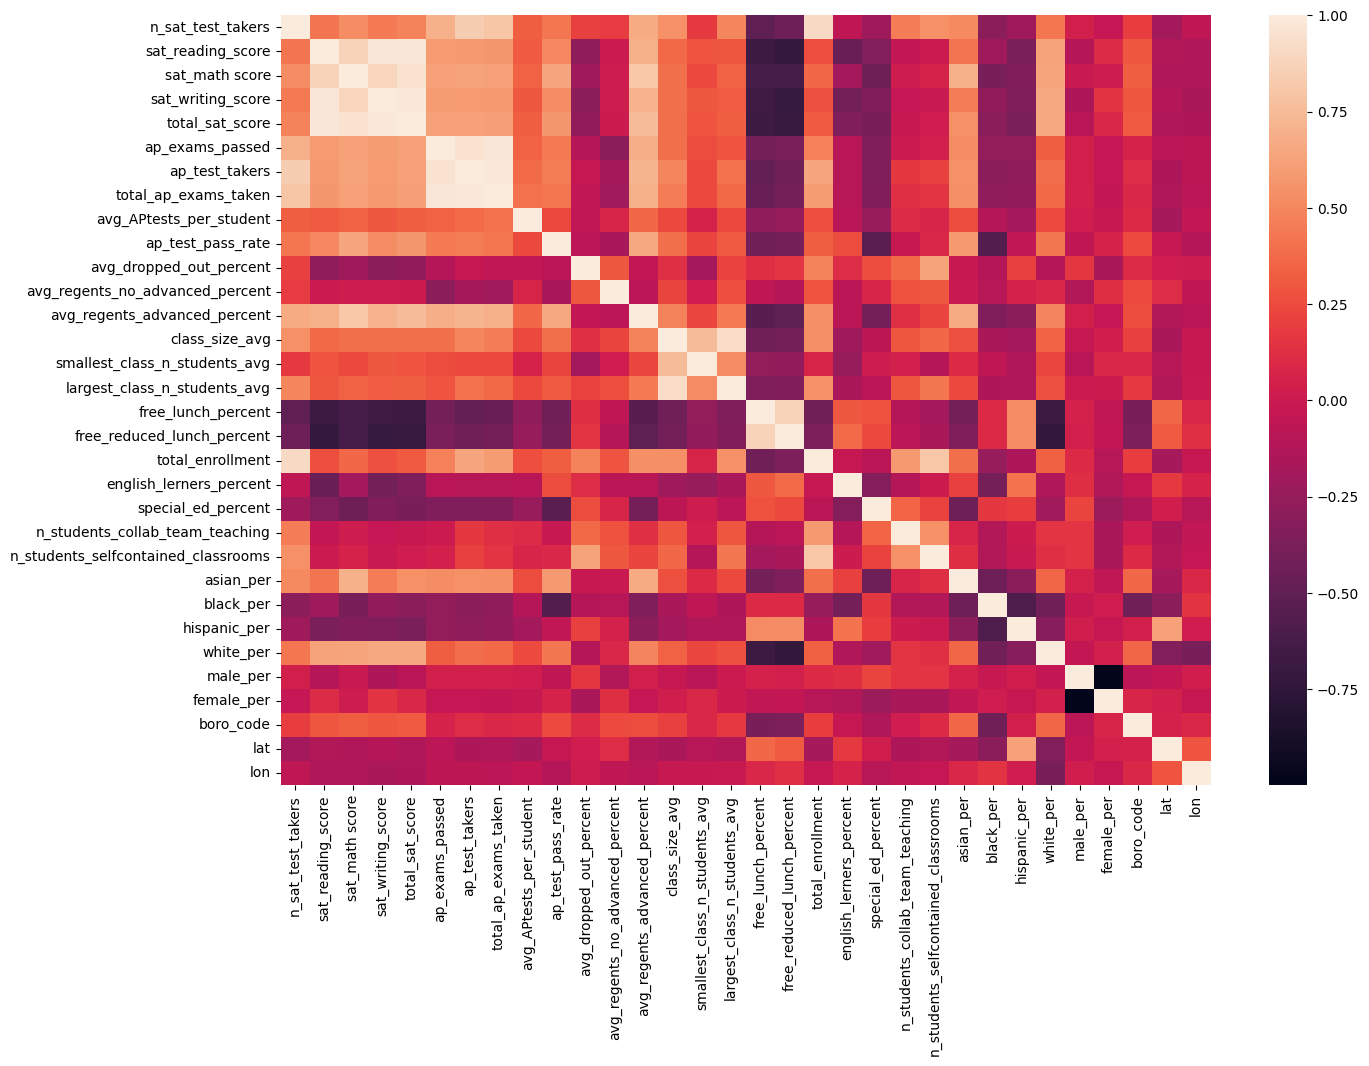

In [13]:
# Produce heatmap of correlation coefficients between SAT scores and metrics
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Limit dataset to numerical values only
combined_sat_data = combined_sat.drop(columns=['DBN', 'school_name'])

# Produce plot
ax, fig = plt.subplots(figsize=(15, 10))
sns.heatmap(combined_sat_data.corr(),
            xticklabels=True,
            yticklabels=True)
plt.show()

There is already some preliminary indication of which factors most strongly affect SAT test outcomes, namely the proportion of students on free or reduced lunch, the proportion of English lerners or special education students, or the proprtion of black or hispanic students, which all have negative correlation coefficients with test result metrics. On the other hand, there are positive correlation coefficients between indicators of positive academic performance and SAT scores, for example the number of AP tests taken at a particular school, the AP test pass rate of a particular school, and the proportion of advanced regents graduates all positively correlate with SAT test scores.

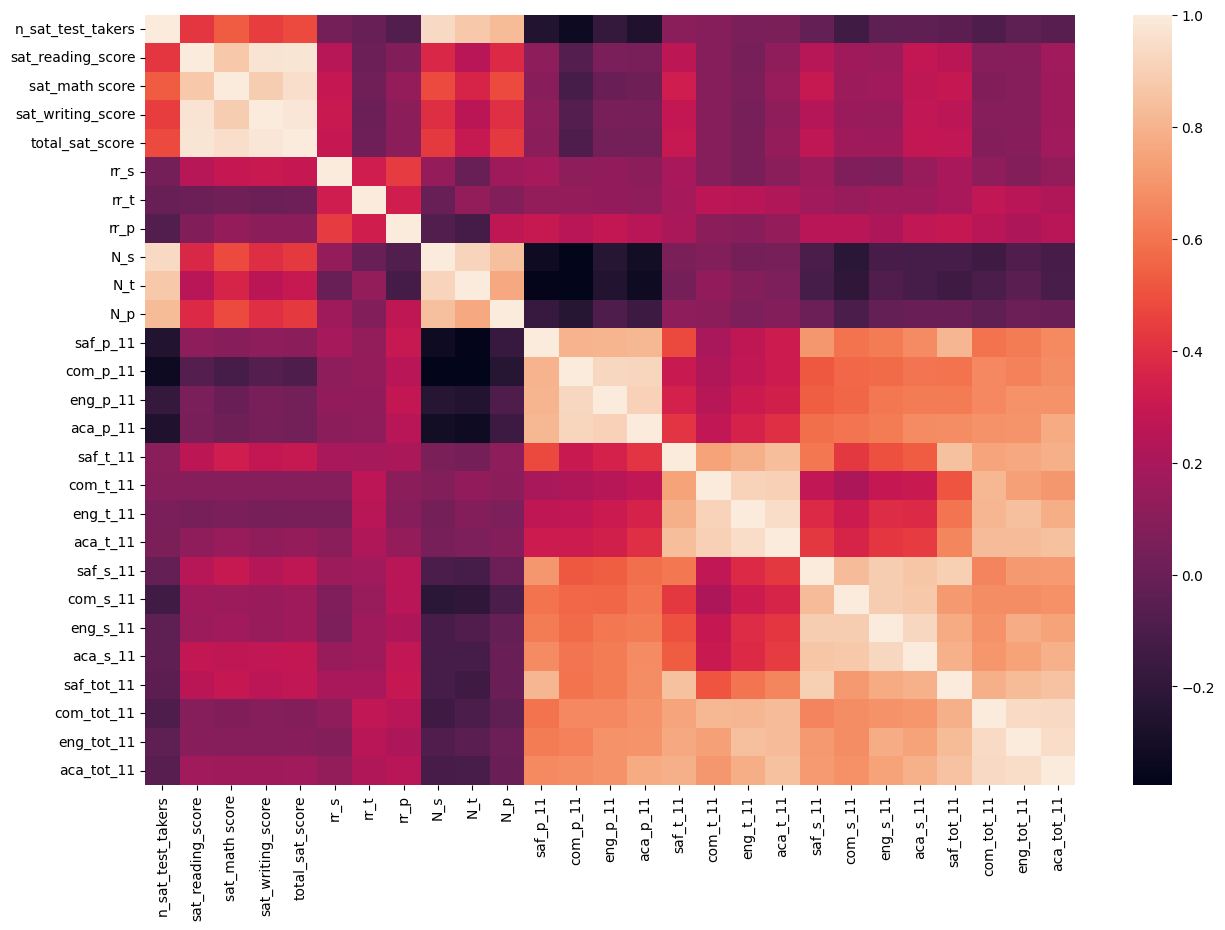

In [14]:
# Produce heat map of correlation coefficients between SAT scores and survey results
# Limit dataset to numerical values only
sat_survey_data = sat_survey.drop(columns=['DBN', 'school_name'])

# Produce plot
ax, fig = plt.subplots(figsize=(15, 10))
sns.heatmap(sat_survey_data.corr(),
            xticklabels=True,
            yticklabels=True)
plt.show()


See the key to survey question abbreviations here:
https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8/about_data

** Note differences in color bar scale between this figure and the last one.

There are also clear correlations observed from the survey results. There are weak negative correlations between parent scoring for safety, communication, engagement, and academic expectations and the number of students taking SAT tests. That is, as the survey scores increase, slightly fewer students on average take SAT exams. This is somewhat counterintuitive.

There are also weak negative correlations between the survey scores and the number of student, teacher, or parent responses to the survey, i.e. the more responses there tend to be, the lower the parent scores tend to be. This may imply that survey engagement is only high among parents when they perceive there is an issue, which may limit the usefulness of this dataset. Notably, however, this is not clearly reflected in the response rate metrics.

The overall engagement of students, parents, and teachers in the survey has a notable positive correlation coefficient with the number of SAT tests taken.

It is also interesting to see the systematic differences between survey responses of parents, teachers, and students. The responses of parents and students have relatively high positive correlation coefficients, implying a high degree of agreement between these groups. On the other hand, the correlation coefficients between the responses of either of these groups and those of teachers is lower - but still positive.

Finally, I note that there are moderately high positive correlation coefficients between the number of SAT takers and SAT scores, implying that schools with more students who self-select to take the SAT are already more likely to have higher performing students compared to schools where fewer students elect to take the SAT.

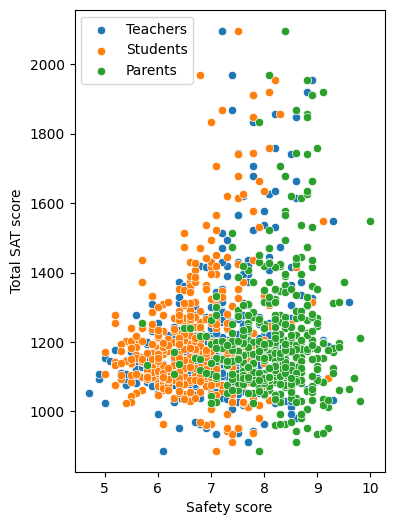

In [15]:
# Zooming in on safety score as a predictor of total SAT score
ax, fig = plt.subplots(figsize=(4, 6))
sns.scatterplot(data=sat_survey, x="saf_t_11", y="total_sat_score", markers='o')
sns.scatterplot(data=sat_survey, x="saf_s_11", y="total_sat_score", markers='^')
sns.scatterplot(data=sat_survey, x="saf_p_11", y="total_sat_score", markers='X')
plt.legend(["Teachers", "Students", "Parents"], loc='upper left')
plt.xlabel("Safety score")
plt.ylabel("Total SAT score")
plt.show()

Looking at the relationship between safety scores and SAT scores in more detail resolves some of the ambiguity. In general, there is no clear trend in any of the datasets, however there is a 'forbidden zone' in which schools with safety scores less than 7 do not have high average SAT scores (> 1600).

In [16]:
# Examine relationship between SAT scores and geography
import folium
from folium.plugins import HeatMap

combined_sat_locs = combined_sat[combined_sat["lat"].notnull() & combined_sat["lon"].notnull()]
max_SAT = combined_sat_locs["total_sat_score"].max()

# Create map
map = folium.Map(location=[40.9, -74], zoom_start=11)
map_wide = HeatMap(list(zip(combined_sat_locs["lat"].values, combined_sat_locs["lon"].values, combined_sat_locs["total_sat_score"].values)),
                   min_opacity=0.4,
                   max_val=max_SAT,
                   radius=25, blur=30,
                   max_zoom=1)
map.add_child(map_wide)

<ipython-input-16-4fe61bf879fc>:10: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  map_wide = HeatMap(list(zip(combined_sat_locs["lat"].values, combined_sat_locs["lon"].values, combined_sat_locs["total_sat_score"].values)),


The map clearly shows that there is a lack of geographical coverage, particularly for Queens and Staten Island. However, some clear trends emerge. High SAT score clusters are clearest in lower Manhattan, midtown Manhattan, southern Bronx, downtown Brooklyn, and Long Island City.  

Note that a clear drawbak to this spatial representation is that high numerical values fade with radius, so a school with a high numerical value for a given parameter but without any other schools nearby will create an "aura" that makes it appear that some areas further away from the school, but still within the designated radius, have a lower numerical value for that parameter. For example, there is blue/purple shading over the East River, implying that SAT scores there are low, but really this just reflects a lack of spatial data in that area. I adjusted the blur and radius settings to try and fix this, but there is a tradeoff with a second effect. In this second effect, nearby schools with overlapping radiuses will sum their parametervalue for a given parameter in the overlapping area. This means that two schools near each other that have a low parameter value will produce a higher apparent parameter value in the map shading for the spatial area where their radii intersect. This tradeoff seems to be an inherent limitation of this tool and should be considered carefully going forward.

In [17]:
# Examine relationship between parent perception of safety/respect and geography
# Prepare datasets
combined_sat_locs_survey = combined_sat_locs.merge(survey, on="DBN", how="left")
combined_sat_locs_survey = combined_sat_locs_survey[combined_sat_locs_survey["saf_p_11"].notnull()]
max_saf_p_11 = combined_sat_locs_survey["saf_tot_11"].max()

# Create map
map = folium.Map(location=[40.9, -74], zoom_start=11)
map_wide = HeatMap(list(zip(combined_sat_locs_survey["lat"].values, combined_sat_locs_survey["lon"].values, combined_sat_locs_survey["saf_p_11"].values)),
                   min_opacity=0.4,
                   max_val=max_saf_p_11,
                   radius=25, blur=30,
                   max_zoom=1)
map.add_child(map_wide)

<ipython-input-17-fddd95b4e276>:9: UserWarning: The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.
  map_wide = HeatMap(list(zip(combined_sat_locs_survey["lat"].values, combined_sat_locs_survey["lon"].values, combined_sat_locs_survey["saf_p_11"].values)),


This map shows generally what is expected based on the observed correlation coefficients: the same areas that have higher average SAT scores also tend to receive higher parent safety/respect scores.

In [18]:
# View spatial distribution of safety scores quantitatively
# Calculate average safety scores by borough
for col in ['saf_s_11', 'saf_p_11', 'saf_t_11', 'saf_tot_11']:
    combined_sat_stats_survey[col] = pd.to_numeric(combined_sat_stats_survey[col], errors='coerce')

safety_by_boro = combined_sat_stats_survey.groupby('boro_code').agg({'boro_code': 'first',
                                                                     'saf_s_11': np.mean,
                                                                     'saf_p_11': np.mean,
                                                                     'saf_t_11': np.mean,
                                                                     'saf_tot_11': np.mean})

# Convert boro_code to boro name and survey question code to description
safety_by_boro['boro'] = safety_by_boro['boro_code'].replace({0: "Brooklyn",
                                                                1: "Bronx",
                                                                2: "Manhattan",
                                                                3: "Queens",
                                                                4: "Staten Island"})
safety_by_boro = safety_by_boro.drop(columns=['boro_code']).reset_index(drop=True)
safety_by_boro = safety_by_boro.rename(columns={'saf_s_11': 'Students',
                                                'saf_p_11': 'Parents',
                                                'saf_t_11': 'Teachers',
                                                'saf_tot_11': 'Average'})

safety_by_boro

<ipython-input-18-641a7761de1f>:6: FutureWarning: The provided callable <function mean at 0x7eac8223fd00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  safety_by_boro = combined_sat_stats_survey.groupby('boro_code').agg({'boro_code': 'first',


,Students,Parents,Teachers,Average,boro
0,6.366337,8.056436,6.995050,7.133663,Brooklyn
1,6.610227,8.337500,7.026136,7.318182,Bronx
2,6.816667,8.260000,7.286250,7.458750,Manhattan
3,6.708475,8.067797,7.349153,7.367797,Queens
4,6.530000,7.800000,7.210000,7.200000,Staten Island


Even though there is clearly a difference ind ata distribution across different boros, the quantitative results imply that, on average, safety scores are roughly the same between different boros.

<ipython-input-19-112b28256a53>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Asian', 'Black', 'Hispanic', 'White'])


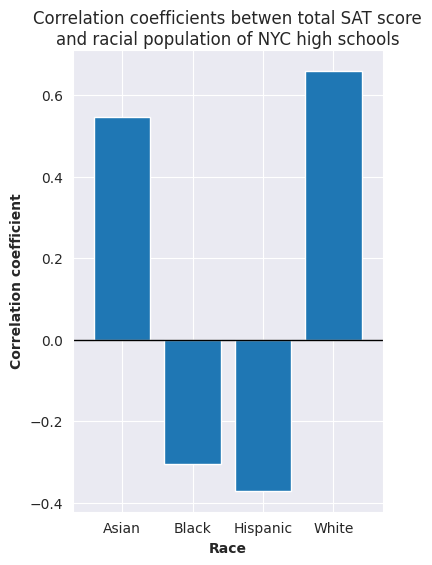

In [19]:
# Explore racial indicators for SAT performance in more detail
# Prepare sub-dataset
sat_race = combined_sat_data.corr().loc[['asian_per', 'black_per', 'hispanic_per', 'white_per'], 'total_sat_score']

# Produce plot
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4, 6))
ax.bar(x=sat_race.index, height=sat_race.values)
ax.set_xticklabels(['Asian', 'Black', 'Hispanic', 'White'])
ax.set_title("Correlation coefficients betwen total SAT score and racial population of NYC high schools", wrap=True)
ax.set_xlabel("Race", weight='bold')
ax.set_ylabel("Correlation coefficient", weight='bold')
ax.hlines(y=0, xmin=-1, xmax=4, linewidth=1, color='black')
ax.set_xlim(-0.7, 3.7)

plt.show()

The chart clearly shows that there is a negative correlation between the proportion of black or hispanic students at a high school and the average SAT score of that school. By contrast, there are positive correlations between the proportion of white or asian students at a school and the average SAT score of that school. This implies that black and hispanic students are disadvantaged when it comes to SAT test taking compared to white or asian students.

In [20]:
# Print stats for schools with highest and lowest hispanic populations
# Prepare sub-datasets
high_hisp = combined_sat[combined_sat['hispanic_per'] > 95].loc[:, ['school_name', 'n_sat_test_takers', 'total_sat_score',
                                                                 'total_enrollment', 'free_reduced_lunch_percent', 'hispanic_per']]
low_hisp = combined_sat[combined_sat['hispanic_per'] < 10].loc[:, ['school_name', 'n_sat_test_takers', 'total_sat_score',
                                                                'total_enrollment', 'free_reduced_lunch_percent', 'hispanic_per']]

# Calculate proportion of SAT takers (note: this is based on total school population, whereas mostly only 11th and 12th grade students will take the SAT, however typically there are a roughly equal number of students per grade)
high_hisp['sat_takers_percent'] = round(high_hisp['n_sat_test_takers'] / high_hisp['total_enrollment'] * 100, 1)
low_hisp['sat_takers_percent'] = round(low_hisp['n_sat_test_takers'] / low_hisp['total_enrollment'] * 100, 1)

# Drop unneeded columns
high_hisp = high_hisp.drop(columns=['n_sat_test_takers', 'total_enrollment'])
low_hisp = low_hisp.drop(columns=['n_sat_test_takers', 'total_enrollment'])

# Rename columns
high_hisp = high_hisp.rename(columns={'school_name': 'School Name',
                                      'hispanic_per': 'Percent of hispanic students',
                                      'free_reduced_lunch_percent': 'Percent of students on free or reduced lunch',
                                      'sat_takers_percent': 'Percent of enrolled students taking SAT',
                                      'total_sat_score': 'Average SAT score',
                                      })
low_hisp = low_hisp.rename(columns={'school_name': 'School Name',
                                    'hispanic_per': 'Percent of hispanic students',
                                    'free_reduced_lunch_percent': 'Percent of students on free or reduced lunch',
                                    'sat_takers_percent': 'Percent of enrolled students taking SAT',
                                    'total_sat_score': 'Average SAT score',
                                    })

# Sort sub-datsets by percent of hispanic students
high_hisp = high_hisp.sort_values(by='Percent of hispanic students', ascending=False)
low_hisp = low_hisp.sort_values(by='Percent of hispanic students', ascending=True)

print('Schools with highest hispanic enrollment: ')
high_hisp.head(10)

Schools with highest hispanic enrollment: 


,School Name,Average SAT score,Percent of students on free or reduced lunch,Percent of hispanic students,Percent of enrolled students taking SAT
105,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,1014.0,95.866667,99.942857,12.7
207,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0,99.700000,99.825000,11.4
334,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0,73.700000,99.750000,19.2
147,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0,89.366667,99.720000,20.6
164,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0,83.466667,99.566667,10.4
48,MANHATTAN BRIDGES HIGH SCHOOL,1058.0,90.366667,99.214286,14.1
98,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0,90.966667,97.200000,18.5
297,MULTICULTURAL HIGH SCHOOL,887.0,76.433333,96.720000,10.0


In [21]:
print('Schools with lowest hispanic enrollment: ')
low_hisp.head(10)

Schools with lowest hispanic enrollment: 


,School Name,Average SAT score,Percent of students on free or reduced lunch,Percent of hispanic students,Percent of enrolled students taking SAT
41,STUYVESANT HIGH SCHOOL,2096.0,36.100000,2.971429,26.1
275,MEDGAR EVERS COLLEGE PREPARATORY SCHOOL,1436.0,76.166667,4.128571,17.3
51,HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES,1424.0,88.400000,4.300000,26.1
5,LOWER EAST SIDE PREPARATORY HIGH SCHOOL,1205.0,89.333333,4.442857,20.7
409,STATEN ISLAND TECHNICAL HIGH SCHOOL,1953.0,16.866667,4.514286,23.7
383,PATHWAYS COLLEGE PREPARATORY SCHOOL: A COLLEGE...,1173.0,53.633333,4.657143,10.6
216,ACADEMY OF BUSINESS AND COMMUNITY DEVELOPMENT,1231.0,65.833333,6.242857,5.2
262,W.E.B. DUBOIS ACADEMIC HIGH SCHOOL,1092.0,75.566667,6.328571,2.5
278,IT TAKES A VILLAGE ACADEMY,963.0,84.033333,6.600000,21.0
266,SCHOOL FOR DEMOCRACY AND LEADERSHIP,1153.0,74.433333,6.642857,9.1


The tables clearly evidence higher SAT scores among the schools with the very lowest hispanic populations, however even those examples with around 6% hispanic student population have comparable average SAT scores to those with more than 95% hispanic student population.

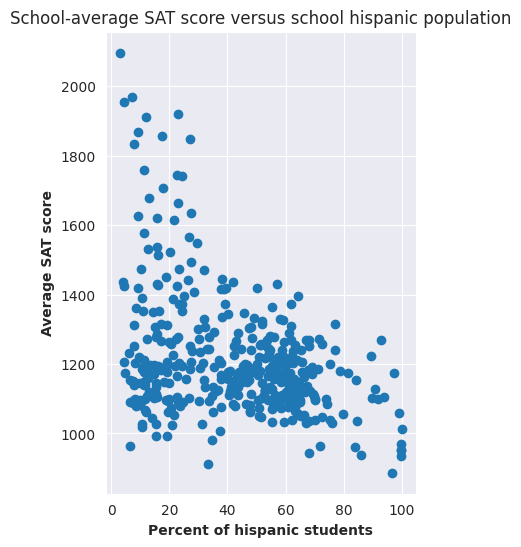

In [22]:
# Generate scatter plot of average SAT score versus hispanic population
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4, 6))
ax.scatter(x=combined_sat['hispanic_per'], y=combined_sat['total_sat_score'])
ax.set_xlabel('Percent of hispanic students', weight='bold')
ax.set_ylabel('Average SAT score', weight='bold')
ax.set_title('School-average SAT score versus school hispanic population')
plt.show()

The scatter plot shows that there is not a simple linear correlation between the percent of hispanic students at a high school and the average SAT score of that high school. There is virtually no correlation between hispanic population and average SAT score for schools with >30% hispanic students. Only schools with lower hispanic populations (< 30%) achieve high average SAT scores (> 1500).

These trends can be partially explained by the targeted nature of some high schools, which provide greater English learning opportunity. Many of the schools listed with the highest hispanic populations are so-called 'bilingual transition schools' that provide students both a general education and help Spanish native speakers with the transition to a predominantly English-speaking city. By contrast, the schools with the lowest proportion of hispanic students and the highest SAT scores are magnet schools with required entrance examinations. This means the students attending these schools are self-selected for high internal motivation - one possible explanation for the relatively high correlation coefficient between academic expectations and SAT score observed previously. Further, the entrance examination for these schools will tend to filter out students with non-English native languages that tend to perform worse on the SAT.

Now I will look more closely at some of the factors associated with race that may have a more straightforward relationship with average SAT scores.

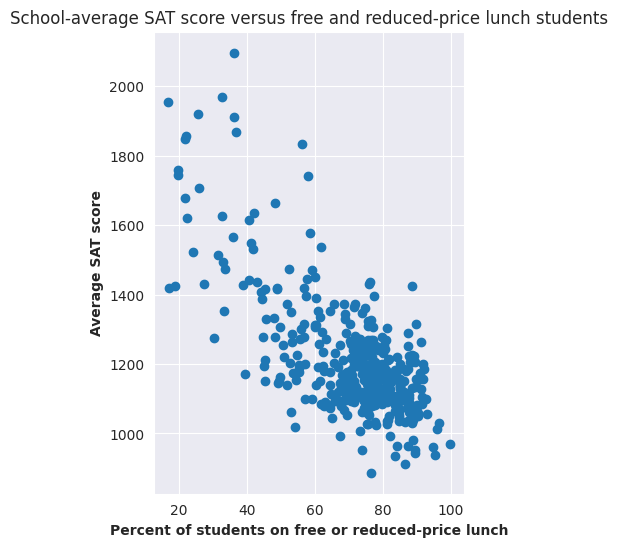

In [23]:
# Generate scatter plot of average SAT score versus percent of students on free or reduced lunch
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4, 6))
ax.scatter(x=combined_sat['free_reduced_lunch_percent'], y=combined_sat['total_sat_score'])
ax.set_xlabel('Percent of students on free or reduced-price lunch', weight='bold')
ax.set_ylabel('Average SAT score', weight='bold')
ax.set_title('School-average SAT score versus free and reduced-price lunch students')
plt.show()

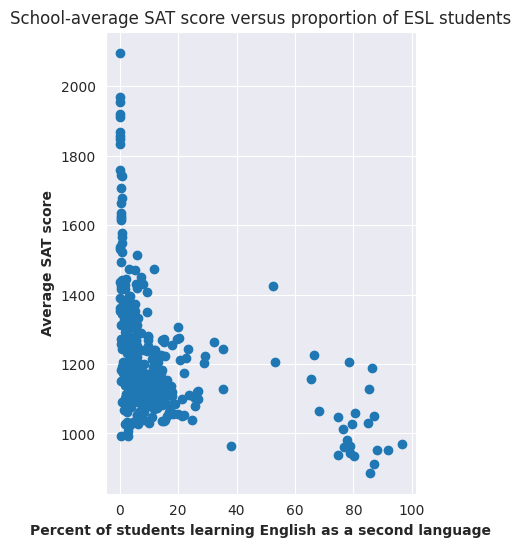

In [24]:
# Generate scatter plot of average SAT score versus percent of students on free or reduced lunch
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4, 6))
ax.scatter(x=combined_sat['english_lerners_percent'], y=combined_sat['total_sat_score'])
ax.set_xlabel('Percent of students learning English as a second language', weight='bold')
ax.set_ylabel('Average SAT score', weight='bold')
ax.set_title('School-average SAT score versus proportion of ESL students')
plt.show()

The plots show that, among the factors investigated so far, the proportion of students receiving free or reduced-price lunch is the most clearly correlated with average school SAT score. There is also a more complex, roughly logarhithmic correlation between the percentage of students learing English as a second language at a school and the average SAT score of that school. However, here there is a clear dichotomy where there are very few schools with a moderate proportion (30-70%) of students learning English because there tend to be specialty schools for ESL students and many schools that have hardly any ESL students.

<ipython-input-25-0e2287c588b7>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Male', 'Female'])


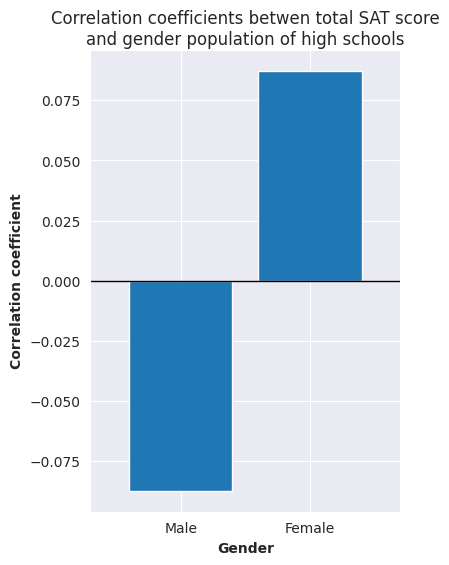

In [25]:
# Explore relationship between gender and SAT scores
# Prepare data
sat_gender = combined_sat_data.corr().loc[['male_per', 'female_per'], 'total_sat_score']

# Produce plot
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4, 6))
ax.bar(x=sat_gender.index, height=sat_gender.values)
ax.set_xticklabels(['Male', 'Female'])
ax.set_title("Correlation coefficients betwen total SAT score and gender population of high schools", wrap=True)
ax.set_xlabel("Gender", weight='bold')
ax.set_ylabel("Correlation coefficient", weight='bold')
ax.hlines(y=0, xmin=-1, xmax=4, linewidth=1, color='black')
ax.set_xlim(-0.7, 1.7)

plt.show()

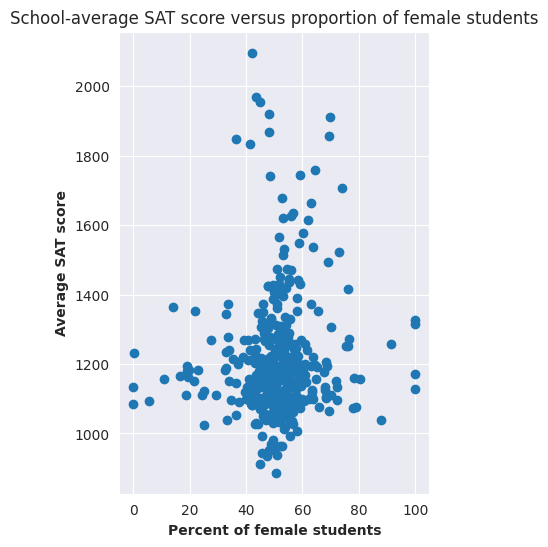

In [26]:
# Generate scatter plot of average SAT score versus percent of female students
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4, 6))
ax.scatter(x=combined_sat['female_per'], y=combined_sat['total_sat_score'])
ax.set_xlabel('Percent of female students', weight='bold')
ax.set_ylabel('Average SAT score', weight='bold')
ax.set_title('School-average SAT score versus proportion of female students')
plt.show()

In [27]:
# Print stats for high-performing schools with highest female populations
# Prepare sub-datasets
high_fem = combined_sat[(combined_sat['total_sat_score'] > 1600) & (combined_sat['female_per'] > 60)].loc[:, ['school_name', 'n_sat_test_takers', 'total_sat_score',
                                                                                                              'total_enrollment', 'free_reduced_lunch_percent', 'female_per']]

# Calculate proportion of SAT takers (note: this is based on total school population, whereas mostly only 11th and 12th grade students will take the SAT, however typically there are a roughly equal number of students per grade)
high_fem['sat_takers_percent'] = round(high_fem['n_sat_test_takers'] / high_fem['total_enrollment'] * 100, 1)

# Drop unneeded columns
high_fem = high_fem.drop(columns=['n_sat_test_takers', 'total_enrollment'])


# Rename columns
high_fem = high_fem.rename(columns={'school_name': 'School Name',
                                    'female_per': 'Percent of female students',
                                    'free_reduced_lunch_percent': 'Percent of students on free or reduced lunch',
                                    'sat_takers_percent': 'Percent of enrolled students taking SAT',
                                    'total_sat_score': 'Average SAT score',
                                      })

# Sort sub-datsets by SAT score
high_fem = high_fem.sort_values(by='Average SAT score', ascending=False)

print('Female-majority schools with highest SAT scores: ')
high_fem.head(10)

Female-majority schools with highest SAT scores: 


,School Name,Average SAT score,Percent of students on free or reduced lunch,Percent of female students,Percent of enrolled students taking SAT
351,TOWNSEND HARRIS HIGH SCHOOL,1910.0,36.266667,69.957143,25.4
8,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,22.000000,69.342857,22.9
30,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0,19.733333,64.385714,25.8
74,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0,26.033333,73.871429,21.0
335,BARD HIGH SCHOOL EARLY COLLEGE II,1663.0,48.366667,62.975000,33.1
31,MILLENNIUM HIGH SCHOOL,1614.0,40.766667,62.128571,25.3


The correlation coefficients between school-average SAT scores and the proportion of male or female students are mutual inverses, which is expected betcause the two measures should have a nearly constant sum. However, the magnitude of the correlation coefficients is low and this is clearly reflected in the scatter plot of school-average SAT score versus the proportion of female students at a school.

It is notable that none of the schools with relatively extreme gender proportions (> 80% or < 20% women) have significantly above-average SAT scores: nearly all schools with high average SAT scores (>1600) have roughly balanced gender populations. However, there is a clear skew among the high-performing schools to slightly female-dominated student populations (50-70%); there are fewer high-achieving schools with 30-50% female population.

The highest-performing schools with female-majority populations tend to be expensive, private college-prep schools (e.g. Bard High School) or specialized public schools (e.g., Fiorello H. Laguardia High School, an arts magnet school). These schools also tend to have entrance examinations, which will pre-select high-performing and test-confident students. Moreover, the proportion of students on free- or reduced-price lunch at these schools is low compared to other examined schools, meaning that economic factors clearly play a stronger role in SAT outcomes than gender alone.

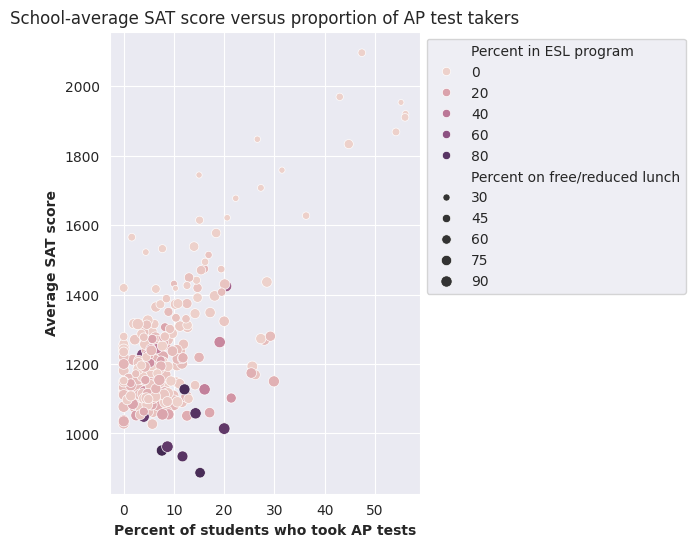

In [28]:
# Examine relationship to AP test takers
# Calculate proportions of AP test takers & create plotting dataset
combined_sat['ap_percent'] = round(combined_sat['ap_test_takers'] / combined_sat['total_enrollment'] * 100, 1)
plotting = combined_sat.loc[:,['ap_percent', 'total_sat_score', 'english_lerners_percent', 'free_reduced_lunch_percent']]
# Rename columns
plotting = plotting.rename(columns={'english_lerners_percent': 'Percent in ESL program',
                                    'free_reduced_lunch_percent': 'Percent on free/reduced lunch'})


# Generate scatter plot of average SAT score versus proportion of SAT test takers
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(4, 6))
sns.scatterplot(data=plotting, x='ap_percent', y='total_sat_score', hue='Percent in ESL program', size='Percent on free/reduced lunch')
ax.set_xlabel('Percent of students who took AP tests', weight='bold')
ax.set_ylabel('Average SAT score', weight='bold')
ax.set_title('School-average SAT score versus proportion of AP test takers')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Here there is also a positive correlation, with schools that have a higher proportion of AP test takers also tending to perform better on the SAT. Combining this with the factors previously identified to be well-correlated to SAT perofrmance, it is clear that only schools with very low proportions of students in ESL programs or on free/reduced-priced lunch have high proportions of test-takers. Thus it is again probably these underlying socioeconomic factors that determine whether a student will take AP tests or score well on the SAT.

# **3. Classifier models**

**A. Prepare datasets**

In [29]:
# Prepare datasets for decision tree classifier, focusing on demographic factors
# Produce one dataset with AP test data and one without
# Focus only on total SAT score, not on sub-test scores

combined_sat_trees = combined_sat_data.drop(columns=['sat_reading_score',
                                                     'sat_math score',
                                                     'sat_writing_score'])
combined_sat_trees_noap = combined_sat_trees.drop(columns=['ap_test_takers',
                                                           'ap_exams_passed',
                                                           'total_ap_exams_taken',
                                                           'avg_APtests_per_student',
                                                           'ap_test_pass_rate'])

# Drop rows with null entries
combined_sat_trees = combined_sat_trees.dropna(axis=0).reset_index(drop=True)
combined_sat_trees_noap = combined_sat_trees_noap.dropna(axis=0).reset_index(drop=True)

# Display length of each dataset
print('Length of dataset with AP test data: ', len(combined_sat_trees))
print('Length of dataset without AP test data: ', len(combined_sat_trees_noap))

Length of dataset with AP test data:  198
Length of dataset without AP test data:  302


In [73]:
# Add coded target column: total AP scores in quartiles
def quantile_label(scores):
  quantiles = []
  a, b, c = np.quantile(scores, [0.25, 0.5, 0.75])
  for entry in scores:
    if entry <= a:
      quantiles.append(1)
    elif entry <= b:
      quantiles.append(2)
    elif entry <= c:
      quantiles.append(3)
    else:
      quantiles.append(4)
  return quantiles

combined_sat_trees['quantile'] = quantile_label(combined_sat_trees['total_sat_score'])
combined_sat_trees_noap['quantile'] = quantile_label(combined_sat_trees_noap['total_sat_score'])

# Check result
combined_sat_trees.head()

,n_sat_test_takers,total_sat_score,ap_exams_passed,ap_test_takers,total_ap_exams_taken,avg_APtests_per_student,ap_test_pass_rate,avg_dropped_out_percent,avg_regents_no_advanced_percent,avg_regents_advanced_percent,...,asian_per,black_per,hispanic_per,white_per,male_per,female_per,boro_code,lat,lon,quantile
0,91.0,1172.0,10.0,39.0,49.0,1.256410,0.204082,6.854545,32.989610,9.279221,...,22.942857,21.642857,46.800000,3.985714,53.014286,46.985714,2.0,40.712332,-73.984797,2
1,70.0,1149.0,0.0,19.0,21.0,1.105263,0.000000,6.306579,59.188158,0.000000,...,6.885714,26.557143,58.471429,6.814286,52.442857,47.557143,2.0,40.729783,-73.983041,2
2,159.0,1621.0,191.0,255.0,377.0,1.478431,0.506631,0.359420,8.768116,33.144928,...,23.057143,10.242857,15.657143,49.771429,46.828571,53.171429,2.0,40.718725,-73.979426,4
3,85.0,1293.0,0.0,21.0,21.0,1.000000,0.000000,2.259259,32.155556,19.890741,...,21.671429,29.685714,35.514286,6.014286,47.800000,52.200000,2.0,40.716412,-73.992676,3
4,48.0,1269.0,10.0,99.0,117.0,1.181818,0.085470,2.681356,39.416949,1.188136,...,4.928571,25.828571,61.814286,4.928571,72.542857,27.457143,2.0,40.765027,-73.992517,3


In [74]:
# Separate target and features variables
X = combined_sat_trees.drop(columns=['total_sat_score', 'quantile'])
y = combined_sat_trees['quantile']
X_noap = combined_sat_trees_noap.drop(columns=['total_sat_score', 'quantile'])
y_noap = combined_sat_trees_noap['quantile']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
X_train_noap, X_test_noap, y_train_noap, y_test_noap = train_test_split(X_noap, y_noap, test_size=0.2, random_state=23)

**B. SGD classifier**

In [75]:
# Instantiate LinearSVC and tune hyperparameters for dataset with AP test data
from sklearn.linear_model import SGDClassifier

alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
states = np.linspace(1, 101, num=20)
accuracies = []

for alpha in alphas:
  for state in states:
    linsvm = SGDClassifier(loss='hinge', alpha=alpha, random_state=23)
    linsvm.fit(X_train, y_train)
    y_pred = linsvm.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    accuracies.append([alpha, state, accuracy])

best = max(range(len(accuracies)), key=lambda i: accuracies[i][2])
print('Best alpha: ', accuracies[best][0], '\n', 'Best random state: ', accuracies[best][1], '\n', 'Best accuracy: ', accuracies[best][2])

Best alpha:  0.01 
 Best random state:  1.0 
 Best accuracy:  0.65


In [76]:
# Instantiate LinearSVC and tune hyperparameters for no-AP dataset
from sklearn.linear_model import SGDClassifier

alphas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
states = np.linspace(1, 101, num=20)
accuracies = []

for alpha in alphas:
  for state in states:
    linsvm = SGDClassifier(loss='hinge', alpha=alpha, random_state=23)
    linsvm.fit(X_train_noap, y_train_noap)
    y_pred_noap = linsvm.predict(X_test_noap)
    accuracy = metrics.accuracy_score(y_test_noap, y_pred_noap)
    accuracies.append([alpha, state, accuracy])

best = max(range(len(accuracies)), key=lambda i: accuracies[i][2])
print('Best alpha: ', accuracies[best][0], '\n', 'Best random state: ', accuracies[best][1], '\n', 'Best accuracy: ', accuracies[best][2])

Best alpha:  0.01 
 Best random state:  1.0 
 Best accuracy:  0.5081967213114754


In [77]:
# Fit model with best hyperparameters and print coefficients
linsvm = SGDClassifier(loss='hinge', alpha=0.01, random_state=1)
linsvm.fit(X_train, y_train)
coef_set = pd.DataFrame({'parameter': X_train.columns, 'coefficient': linsvm.coef_[0]}).sort_values(by='coefficient', ascending=False)
coef_set

,parameter,coefficient
18,n_students_selfcontained_classrooms,136.096732
15,english_lerners_percent,74.286303
12,free_lunch_percent,65.218459
20,black_per,57.251250
13,free_reduced_lunch_percent,49.996509
21,hispanic_per,49.876813
23,male_per,38.502037
6,avg_dropped_out_percent,20.443589
16,special_ed_percent,16.961833
11,largest_class_n_students_avg,3.295826


In [78]:
# Fit model with best hyperparameters and print coefficients
linsvm_noap = SGDClassifier(loss='hinge', alpha=0.01, random_state=1)
linsvm_noap.fit(X_train_noap, y_train_noap)
coef_set_noap = pd.DataFrame({'parameter': X_train_noap.columns, 'coefficient': linsvm_noap.coef_[0]}).sort_values(by='coefficient', ascending=False)
coef_set_noap

,parameter,coefficient
10,english_lerners_percent,53.323178
15,black_per,24.355092
13,n_students_selfcontained_classrooms,23.116722
1,avg_dropped_out_percent,19.892841
7,free_lunch_percent,16.515991
12,n_students_collab_team_teaching,14.191897
16,hispanic_per,12.864667
22,lon,10.646783
2,avg_regents_no_advanced_percent,9.094891
6,largest_class_n_students_avg,2.343319


**C. Decision tree classifier**

In [79]:
# Import libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': np.arange(3, 30, 3),
              'min_samples_split': np.arange(2, 10, 2),
              'min_samples_leaf': np.arange(1, 20, 2)}

# Instantiate model
clf = DecisionTreeClassifier()
clf_cv = GridSearchCV(clf, param_grid, cv=4)
clf_cv.fit(X_train, y_train)

# Print best hyperparameters
print('Best hyperparameters: ', clf_cv.best_params_)
print('Best score: ', clf_cv.best_score_)

Best hyperparameters:  {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 6}
Best score:  0.6067307692307693


In [80]:
# Define hyperparameter grid for no-AP dataset
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': np.arange(3, 30, 3),
              'min_samples_split': np.arange(2, 10, 2),
              'min_samples_leaf': np.arange(1, 20, 2)}

# Instantiate model
clf_noap = DecisionTreeClassifier()
clf_noap_cv = GridSearchCV(clf, param_grid, cv=4)
clf_noap_cv.fit(X_train_noap, y_train_noap)

# Print best hyperparameters
print('Best hyperparameters: ', clf_noap_cv.best_params_)
print('Best score: ', clf_noap_cv.best_score_)

Best hyperparameters:  {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 4}
Best score:  0.5683060109289617


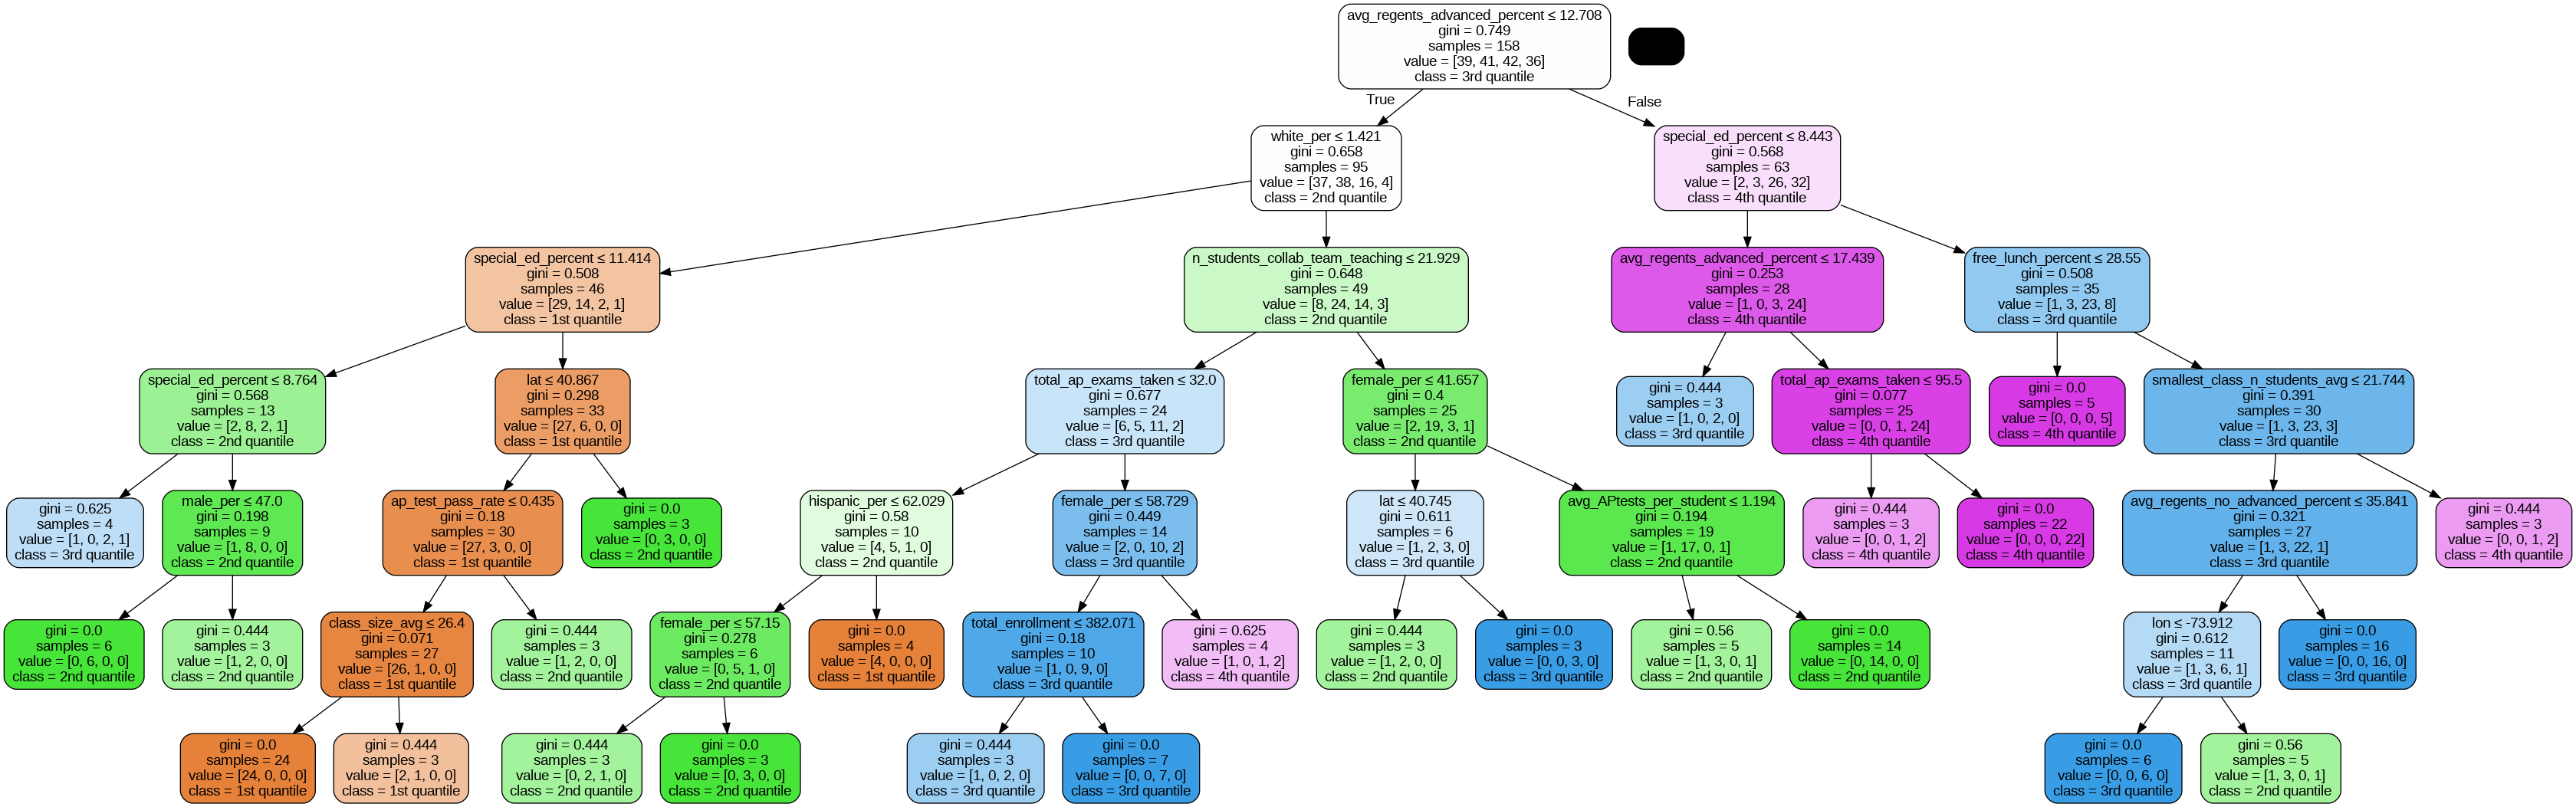

In [82]:
# Visualize decision tree for dataset including AP data
from sklearn.tree import export_graphviz
from io import StringIO
from IPython.display import Image
import pydotplus

# Perform model fit with best hyperparameters
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=12,
                             min_samples_leaf=3,
                             min_samples_split=6)
clf.fit(X_train, y_train)

# Generate visualization
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True,
                feature_names=X_train.columns,
                class_names=['1st quantile', '2nd quantile', '3rd quantile', '4th quantile']
                )
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_png('nyc_schools_tree.png')
Image(graph.create_png())

The best-performing decision tree has a test set accuracy similar to the linear classifier model. Interestingly, while the linear classifier model places high weights on features like the proportion of ESL learners or the proportion of students receiving free or reduced-price lunch (much like the manual data analysis), the most important factors in the decision tree are racial. Other factors relevant to the decision tree include the proportion of students in special education classes (considered roughly equivalent to the number of students in self-contained classrooms, which tend to be special education environments) or the proportion of students who drop out of school.

Based on the decision tree, the highest performing schools have low proportions of special education students and free or reduced-price lunch students, smaller class sizes, higher proportions of advanced regents graduates, higher numbers of AP tests taken, and are more female dominated. Interestingly, geography plays a low-order role in the classification tree, with more northerly schools having slightly better SAT performance compared to more southerly schools.

It is noteworthy that in no case are the classifier models very accurate against the test datasets. In repeated tests, reducing the number of classes in the target variable improves accuracy, which means that the model is likely limited by the size of the dataset, which inhibits more granular discrimination of test performance. Since the dataset is more than 10 years old, perhaps newer datasets are available that would aid in the analysis.

# **4. Conclusion**

The descriptive data analysis reveals that socioeconomic factors, many of which underlie race differences, are likely the primary drivers of differences in SAT test performance among NYC high schools. There are likely internal correlations between the data features in this way: for example, schools with proportionally higher black or hispanic populations are more likely to have more students on free or reduced lunch, or to have a low safety perception. A linear classifier model used on demographic indicators largely agrees wtih this analysis. However, a decision tree classifier assigns higher importance to race itself, as well as factors such as the proportion of special education students, which was not explicitly studied in the manual data description. Additionally, the tree classifier uses information such as the proportion of female students and class size to discriminate the highest-performing schools, while in the manual data description these factors were shown to only have a complex relationship with school-wide average SAT scores.

Overall, it is clear that the linear classifier models are a more efficient way to identify the features that play the largest roles in multi-dimensional datasets. The tree classifier, in particular, offered good accuracy, but in all cases it appears that the classifiers are limited by the size of the dataset. Future work may attempt to aggregate data from more schools, particularly from underrepresented geographical areas in Brooklyn and Queens, in order to develop a better analysis.